In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from fracdiff.sklearn import Fracdiff
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

In [2]:
def returns(y_true, y_pred):
    pred_sign = np.sign(y_pred)
    y_true = np.squeeze(y_true)
    returns = np.where((pred_sign == 1), y_true, 0)
    returns = np.where((pred_sign == -1), y_true * -1, returns)
    return returns.sum()
returnScorer = make_scorer(returns, greater_is_better=True)

def create_target(df, target, name, lookforward=1):
    df[name] = np.log(df[target].shift(periods=-lookforward)/df[target])
    return df

In [3]:
ticker = 'VB' #VB is a small cap etf, which might have more alpha than large caps
df = yf.download(ticker, period='2y', interval='1h', progress=False) #intraday data might have more alpha than daily data
# df = yf.download(ticker, period='max')
lookforward = 1
df = create_target(df, 'Close', 'Target', lookforward=lookforward)
df.dropna(inplace=True)
X = df['Close']
X = X.values.reshape(-1,1) # dont use this if you have more than 1 column in X
y = df['Target']

In [4]:
tscv = TimeSeriesSplit(n_splits=2, gap=lookforward)
model = LinearRegression(fit_intercept=False)
pipe = Pipeline([
    ('fracdiff', Fracdiff()),
    ('model', model)
])
param_dist = {
    'fracdiff__d': np.arange(0.01, .99, 0.01),
    'fracdiff__window': np.arange(2, (21*12) + 1, 1),
}

In [ ]:
search = GridSearchCV(pipe, param_grid=param_dist, cv=tscv, scoring=returnScorer, n_jobs=-1, verbose=0)
search.fit(X, y)

In [6]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation returns: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(search.cv_results_)

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 185}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 186}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 187}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 188}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 189}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 190}

Model with rank: 1
Mean validation returns: 0.223 (std: 0.114)
Parameters: {'fracdiff__d': 0.9500000000000001, 'fracdiff__window': 191}

Model with rank: 1
Mean validation return

In [7]:
logX = np.log(df['Close']/df['Close'].shift(1))
logX = logX.values.reshape(-1,1)

logReturns = cross_val_score(estimator=model, X=logX[1:], y=y[1:], scoring=returnScorer, cv=tscv, n_jobs=-1)
print("Log returns:")
print("Mean returns:", logReturns.mean())
print("Std Dev returns: +/-", logReturns.std())
print("")

longOnly = cross_val_score(estimator=DummyRegressor(strategy='constant', constant=1), X=X, y=y, scoring=returnScorer, cv=tscv, n_jobs=-1)
print("Long only returns:")
print("Mean returns:", longOnly.mean())
print("Std Dev returns: +/-", longOnly.std())
print("")

shortOnly = cross_val_score(estimator=DummyRegressor(strategy='constant', constant=-1), X=X, y=y, scoring=returnScorer, cv=tscv, n_jobs=-1)
print("Short only returns:")
print("Mean returns:", shortOnly.mean())
print("Std Dev returns: +/-", shortOnly.std())
print("")

Log returns:
Mean returns: 0.11142995266020206
Std Dev returns: +/- 0.08633002825746344

Long only returns:
Mean returns: -0.08188057423801234
Std Dev returns: +/- 0.015627812388024347

Short only returns:
Mean returns: 0.08188057423801234
Std Dev returns: +/- 0.015627812388024347



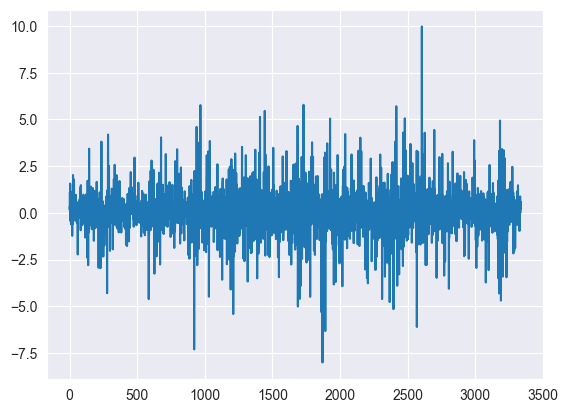

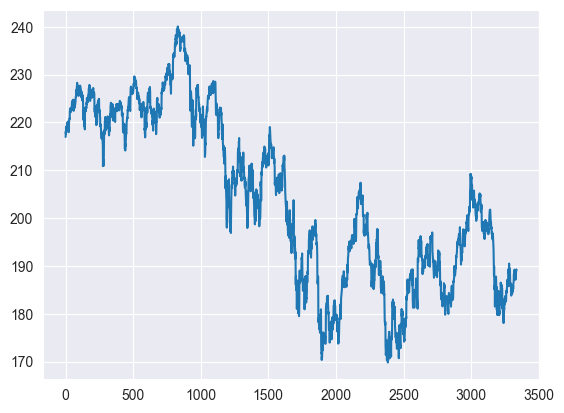

In [8]:
fracDiff = Fracdiff(d=search.best_params_['fracdiff__d'], window=search.best_params_['fracdiff__window']).fit_transform(X)
fracDiff = fracDiff[search.best_params_['fracdiff__window']:]
close = df['Close'].values[search.best_params_['fracdiff__window']:]
plt.plot(fracDiff)
plt.show()
plt.plot(close)
plt.show()

C:\Users\AppData\Local\Temp\ipykernel_2788\3232816214.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


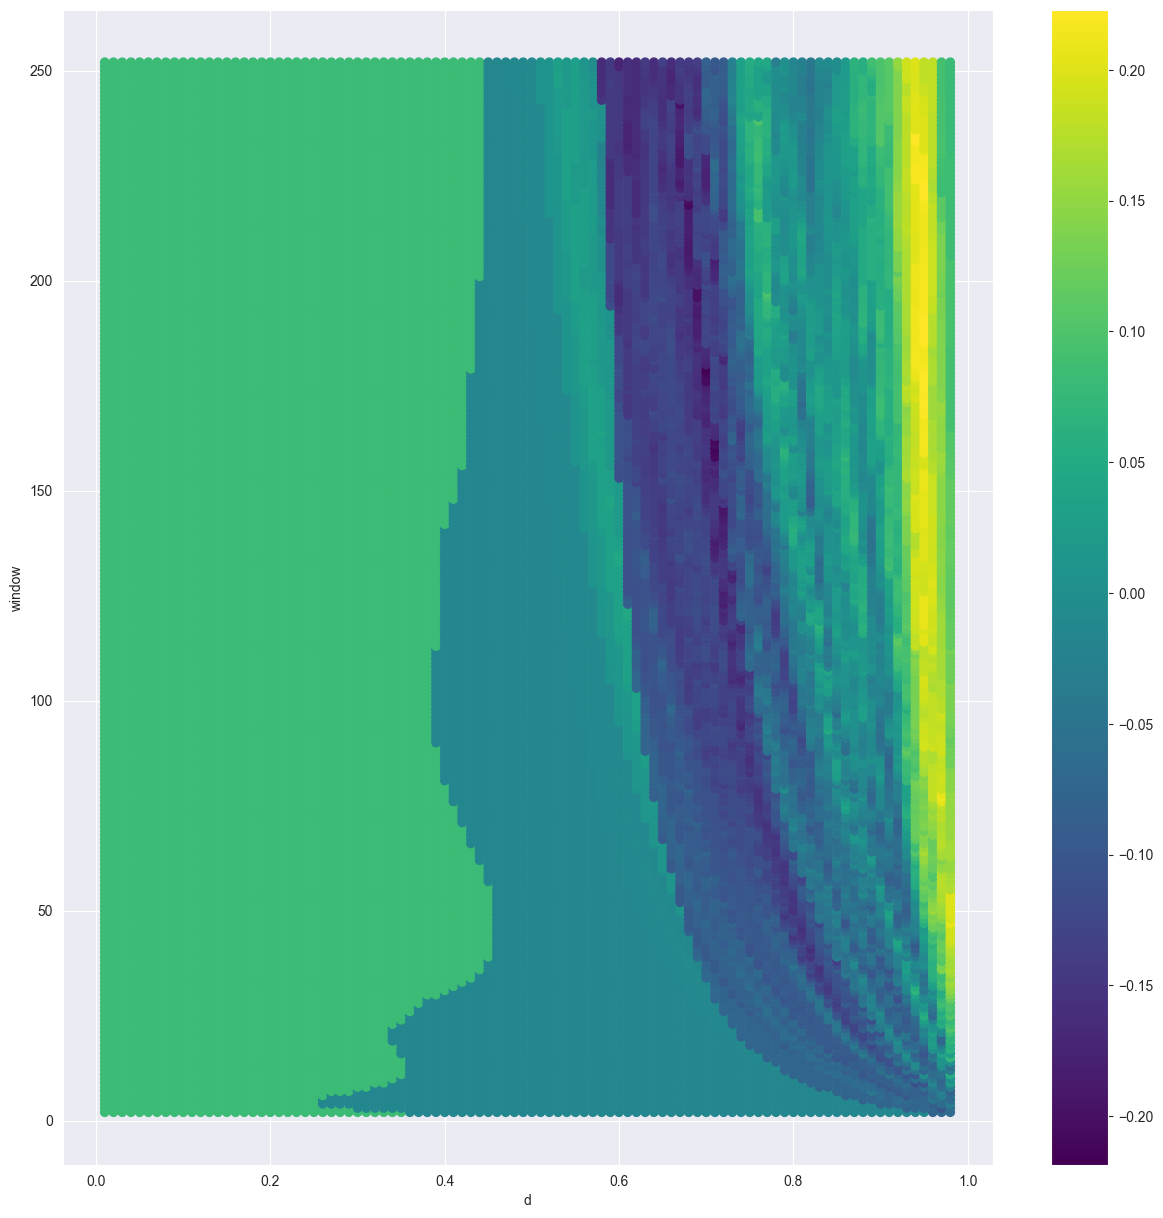

In [10]:
plt.figure(figsize=(15,15))
plt.scatter(search.cv_results_['param_fracdiff__d'], search.cv_results_['param_fracdiff__window'], c=search.cv_results_['mean_test_score'], cmap='viridis')
plt.colorbar()
plt.xlabel('d')
plt.ylabel('window')
plt.show()